In [1]:
import pyvisa
from labjack import ljm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyqtgraph.Qt import QtGui, QtWidgets
import pyqtgraph as pg
%matplotlib inline
import base64
import sys
import time
import pyvisa
from time import sleep
from simple_pid import PID

In [2]:
R = 50
desired_power = 0
desired_voltage = (desired_power*R)**0.5
channel = 1
#instrument.write(f'OUT {channel}')
instrument.write(f'VOLT {desired_voltage}')
# Verify the set voltage
instrument.write('VOLT?')
current_voltage = float(instrument.read())
print(f'Voltage set to: {current_voltage}V')
instrument.write('MEAS:CURR?')
current_current = float(instrument.read())
print(f'Voltage set to: {current_current}A')
print(f'Heater Power (Predicted): {current_voltage**2/50}W')
print(f'Heater Power (Actual): {current_current*current_voltage}W')

NameError: name 'instrument' is not defined

In [10]:
# Initialize the PID
# Note: I've been pre-warming the heater by setting to 3 volts for ~30 minutes
Kp0 = 5
Ki0 = 0.025
Kd0 = 0.01
sp0 = 295#300
pid = PID(Kp0, Ki0, Kd0, setpoint=sp0)
pid.output_limits = (0, 10)
pid.sample_time = 0.1
# Initialize VISA resource manager
rm = pyvisa.ResourceManager()  # '@py' specifies the pyvisa-py backend

# Open the serial connection to the Keysight power supply
# Replace 'ASRL::COM3::INSTR' with your correct serial port
#instrument = rm.open_resource('ASRL8::INSTR', baud_rate=9600, data_bits=8, parity=pyvisa.constants.Parity.none, stop_bits=pyvisa.constants.StopBits.one)
instrument = rm.open_resource('GPIB0::4::INSTR')

# Set timeout (optional)
instrument.timeout = 5000  # 5 seconds timeout

# Check if the instrument is responding
instrument.write('*IDN?')  # Query the device identification
response = instrument.read()
print(f'Device ID: {response}')

# Select Channel
instrument.write('INST:SEL OUT1')

# Set the output voltage (for example, 5V)
desired_voltage = 0.0
instrument.write(f'VOLT {desired_voltage}')

# Verify the set voltage
instrument.write('VOLT?')
current_voltage = instrument.read()
print(f'Voltage set to: {current_voltage}V')

# Turn on the output
instrument.write('OUTPUT 1')

pg.setConfigOptions(antialias=True)

app = pg.mkQApp("Glow Example")


children = [
    dict(name='Setpoint', type='float', limits=[250,310], value=sp0, step=0.1),
    dict(name='Kp', type='float', limits=[0, 1000], value=Kp0, step=0.1),
    dict(name='Ki', type='float', limits=[0, 2], value=Ki0, step=0.1),
    dict(name='Kd', type='float', limits=[0, 2], value=Kd0, step=0.1),
]

params = pg.parametertree.Parameter.create(name='Parameters', type='group', children=children)
pt = pg.parametertree.ParameterTree(showHeader=False)
pt.setParameters(params)

pw1 = pg.PlotWidget()
pw1.showGrid(x=True,y=True)
pw2 = pg.PlotWidget()
pw2.showGrid(x=True,y=True)

splitterv = QtWidgets.QSplitter()
splitterv.setOrientation(pg.QtCore.Qt.Vertical)
splitterv.addWidget(pw1)
splitterv.addWidget(pw2)

splitter = QtWidgets.QSplitter()
splitter.addWidget(pt)
splitter.addWidget(splitterv)
# splitter.addWidget(pw1)
# splitter.addWidget(pw2)
splitter.show()



# Window stuff
# win = pg.GraphicsLayoutWidget(show=True)
# win.setWindowTitle('pyqtgraph example: Scrolling Plots')
# p1 = win.addPlot()
# p1.setDownsampling(mode='peak')
# p1.showGrid(x=True, y=True)
# p1curve = p1.plot(pen=(0,255,255))
# win.nextRow()
# p2 = win.addPlot()
# p2.setDownsampling(mode='peak')
# p2.showGrid(x=True, y=True)
# p2curve = p2.plot(pen=(0,255,255))
# win.nextRow()
# p3 = win.addPlot()
# p3.setDownsampling(mode='peak')
# p3.showGrid(x=True, y=True)
# p3curve = p3.plot(pen=(0,255,255))


handle = ljm.openS("ANY", "ANY", "ANY")  # Any device, Any connection, Any identifier

info = ljm.getHandleInfo(handle)
print("Opened a LabJack with Device type: %i, Connection type: %i,\n"
      "Serial number: %i, IP address: %s, Port: %i,\nMax bytes per MB: %i" %
      (info[0], info[1], info[2], ljm.numberToIP(info[3]), info[4], info[5]))

names = ["AIN0"]
samp_rate = 12 # Samples per second
runtime = 5 # in seconds
#Init dataframe 
data = {'Time (Datenum)': [], 'Temp (K)': [], 'PS Output (V)': [],}
dnames = data.keys()

tstart = time.time()
def update1():
    pw1.clear()
    pw2.clear()
    
    global data
    tloop = time.time()
    Ttemp = []
    Ltemp = []
    ttemp = []
    while np.abs(time.time()-tloop)<1/samp_rate:
        ttemp.append(time.time())
        T = ljm.eReadName(handle, names[0])*100+273.15
        Ttemp.append(T)
        instrument.write('VOLT?')
        time.sleep(0.1)
        PSV = float(instrument.read())
        Ltemp.append(PSV)
        # Update the PID
        newV = pid(T)
        print(f'\r{newV}',end='')
        instrument.write(f'VOLT {newV}')
        instrument.write(f'SYST:ERR?')
        errcheck = instrument.read()
        if int(errcheck.split(',')[0])<0:
            print(errcheck)
            break
    data['Time (Datenum)'].append(float(np.median(ttemp)))
    data['Temp (K)'].append(float(np.median(Ttemp)))
    data['PS Output (V)'].append(float(np.median(Ltemp)))
    # p1curve.setData(np.array(data['Time (Datenum)'])-tstart,data['Temp (C)'])
    # p2curve.setData(np.array(data['Time (Datenum)'])-tstart,data['PS Output (V)'])
    # #p3curve.setData(np.array(data['Time (Datenum)'])-tstart,data['PS Output (V)'])
    pw1.addItem(pg.PlotDataItem(np.array(data['Time (Datenum)'])-tstart,data['Temp (K)'],pen=(0,255,255)))
    pw2.addItem(pg.PlotDataItem(np.array(data['Time (Datenum)'])-tstart,data['PS Output (V)'],pen=(0,255,255)))

    pid.Kp = params.child('Kp').value()
    pid.Ki = params.child('Ki').value()
    pid.Kd = params.child('Kd').value()
    pid.setpoint = params.child('Setpoint').value()
# update all plots
def update():
    update1()

timer = pg.QtCore.QTimer()
timer.timeout.connect(update)
timer.start(50)

if __name__ == '__main__':
    pg.exec()

    # Close handle
    ljm.close(handle)
    # Close the connection when done
    instrument.write('VOLT 0')
    instrument.write('OUTPUT 0')
    instrument.close()

Device ID: Agilent Technologies,E3647A,0,2.4-6.1-2.1

Voltage set to: +0.00000000E+00
V
Opened a LabJack with Device type: 7, Connection type: 1,
Serial number: 470035776, IP address: 0.0.0.0, Port: 0,
Max bytes per MB: 64
2.892546444420943444

In [20]:
df = pd.DataFrame(data)
#df = df.drop(index = 0)
csv_file = 'C:/Users/jcornelison/Documents/GitHub/PROWLS-Control/Data/Temp_Dependence_with_heater/Tables/PID_setup_21apr2025.csv'
df.to_csv(csv_file, index = False)
#log_and_print(f"The data has been saved to {csv_file}, previous file may have been overwritten.")
pd.read_csv(csv_file)

,Time (Datenum),Temp (K),PS Output (V)
0,1.727818e+09,299.999490,0.000000
1,1.727818e+09,299.983701,0.005113
2,1.727818e+09,299.983701,0.164155
3,1.727818e+09,299.991596,0.163641
4,1.727818e+09,299.991596,0.084556
...,...,...,...
200887,1.727878e+09,300.023174,3.274685
200888,1.727878e+09,300.023174,3.272960
200889,1.727878e+09,300.015280,3.272706
200890,1.727878e+09,300.031069,3.352933


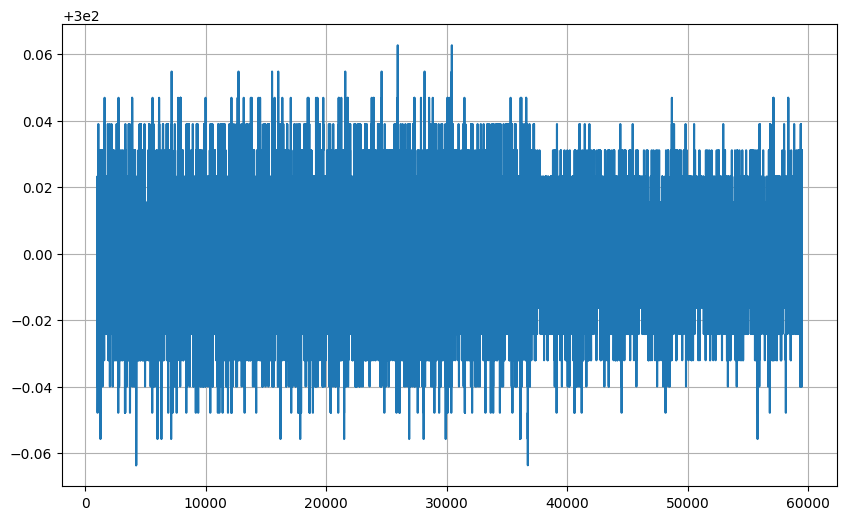

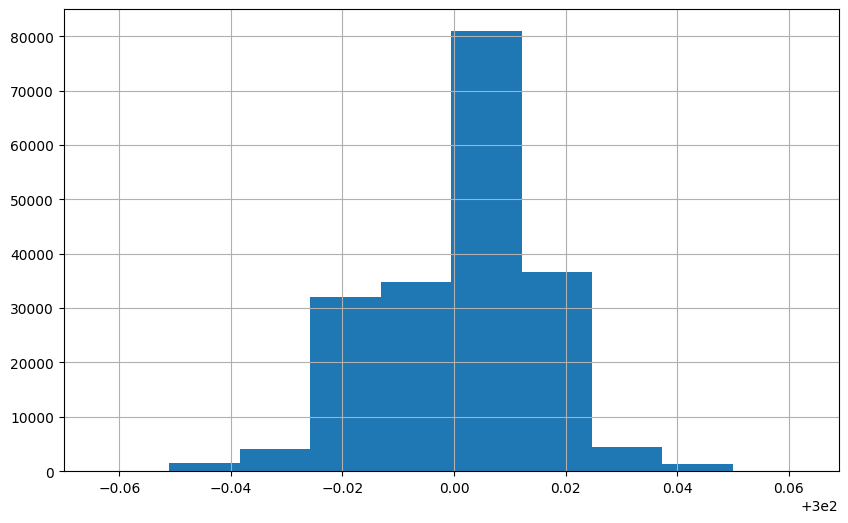

0.014633255332690021


In [27]:
kys = df.keys();
idx = np.arange(5000,len(df))
plt.figure(1,figsize=(10,6))
#plt.subplot(3,1,1)
plt.plot(df[kys[0]][idx]-df[kys[0]][0],df[kys[1]][idx])
plt.grid(True)
plt.show()
plt.figure(2,figsize=(10,6))
#plt.subplot(3,1,1)
plt.hist(df[kys[1]][idx])
plt.grid(True)


plt.show()
print(np.std(df[kys[1]][idx]))

In [3]:
rm = pyvisa.ResourceManager()  # '@py' specifies the pyvisa-py backend

# Open the serial connection to the Keysight power supply
# Replace 'ASRL::COM3::INSTR' with your correct serial port
instrument = rm.open_resource('ASRL8::INSTR', baud_rate=9600, data_bits=8, parity=pyvisa.constants.Parity.none, stop_bits=pyvisa.constants.StopBits.one)

# Set timeout (optional)
instrument.timeout = 5000  # 5 seconds timeout

# Check if the instrument is responding
instrument.write('*IDN?')  # Query the device identification
response = instrument.read()
print(f'Device ID: {response}')

instrument.write('VOLT 0')
instrument.write('OUTPUT 0')
instrument.close()
ljm.close(handle)

Device ID: Agilent Technologies,E3647A,0,2.4-6.1-2.1



NameError: name 'handle' is not defined

In [67]:
# Initialize VISA resource manager
rm = pyvisa.ResourceManager()  # '@py' specifies the pyvisa-py backend

# Open the serial connection to the Keysight power supply
# Replace 'ASRL::COM3::INSTR' with your correct serial port
instrument = rm.open_resource('ASRL8::INSTR', baud_rate=9600, data_bits=8, parity=pyvisa.constants.Parity.none, stop_bits=pyvisa.constants.StopBits.one)

# Set timeout (optional)
instrument.timeout = 5000  # 5 seconds timeout

# Check if the instrument is responding
instrument.write('*IDN?')  # Query the device identification
response = instrument.read()
print(f'Device ID: {response}')

# Select Channel
instrument.write('INST:SEL OUT1')

# Set the output voltage (for example, 5V)
desired_voltage = 0.0
instrument.write(f'VOLT {desired_voltage}')

# Verify the set voltage
instrument.write('VOLT?')
current_voltage = instrument.read()
print(f'Voltage set to: {current_voltage}V')

# # Turn on the output
# instrument.write('OUTPUT 1')
instrument.write('SYST:ERR?')
print(instrument.read())
instrument.write('*CLS')

Device ID: Agilent Technologies,E3647A,0,2.4-6.1-2.1

Voltage set to: +0.00000000E+00
V
+0,"No error"



6

In [76]:
# Create a central widget
central_widget = QtWidgets.QWidget()
self.setCentralWidget(central_widget)


# Creat window 
app = QtWidgets.QApplication()
Qwin = QtWidgets.QMainWindow()
# Create a layout
layout = QtWidgets.QHBoxLayout()
central_widget.setLayout(layout)

children = [
    dict(name='Kp', type='float', limits=[0, 1], value=0.0, step=0.1),
    dict(name='Kd', type='float', limits=[0, 1], value=0.0, step=0.1),
    dict(name='Ki', type='float', limits=[0, 1], value=0.0, step=0.1),
]

params = pg.parametertree.Parameter.create(name='Parameters', type='group', children=children)
pt = pg.parametertree.ParameterTree(showHeader=False)
pt.setParameters(params)
